inactivation_19.57.25.rec
24
16
24
Experiment Recording: inactivation_19.57.25.rec
Number of Sweeps: 12
Well ID: C14
IV Data: Yes
Leak Data recorded: Yes
Sample Count: 3600


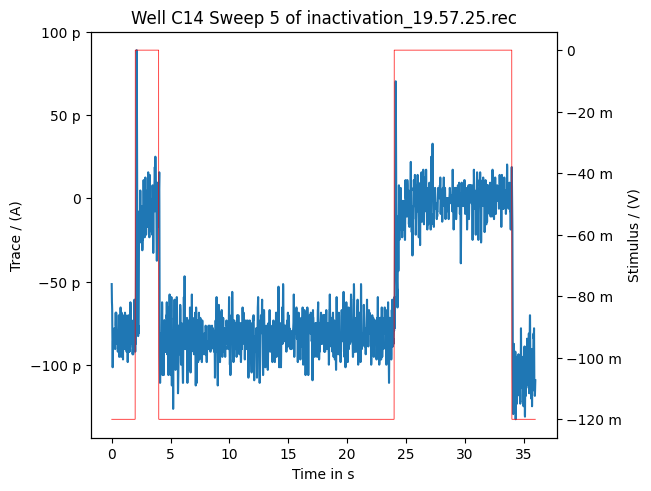

In [12]:
# tester to load nanion files

# this piece came from nanion themselve:

# Import JSON Module
import json

# Other Modules
import os.path, struct
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

########## Parameter Configuration #########
# json_file = r"C:\RecordedData\TestData\02_TestData 384\Analysis_tests\Blocker Test\Kv4.3_1XM_01-05\Kv4.3_CiPA_12.51.01\Kv4.3_CiPA_12.51.01.json"    # Blocker Example
# json_file = r"C:\RecordedData\IV TestData\20220111 Markus Testdaten\NaIV-80hold_13.11.50\NaIV-80hold_13.11.50.json"   # IV Masurement
# json_file = r"C:\RecordedData\TestData\02_TestData 384\Partielle Platte\PartialPlate_NiB\190424_Air\n4_air_lowVol_1xh_PP_012\hERGPharm_15.54.43\hERGPharm_15.54.43.json"    # Partial Plate

# test files i got: 
json_file = r"C:\Users\davee\Dropbox\dave\WP\biophysical_essentials\Nav1.3_1.7IT_25deg_1xS_21T04344\Nav1.3_1.7IT_25deg_1xS_21T04344\inactivation_19.57.25\inactivation_19.57.25.json"

Well_ID_Row = 2         # Well Identification, Counting starts at 0
Well_ID_Column = 13     # Well Identification, Counting starts at 0, all Wells count (also in PartialPlate)
Sweep = 5               # Sweep Number to read, Counting starts at 0
############################################

# Read the whole JSON file into the recording-data dictionary
with open(json_file.replace("\\", "/"), 'r') as file:
    recording_data = json.load(file)

# Read out all necessary information from JSON file
DataName =      recording_data["DatasetIdentifier"]["DataName"]
WP_nCols =      recording_data["TraceHeader"]["Chiplayout"]["WP_nCols"]             # Chip Information: Number of Columns
WP_nRows =      recording_data["TraceHeader"]["Chiplayout"]["WP_nRows"]             # Chip Information: Number of Rows
nCols =         recording_data["TraceHeader"]["MeasurementLayout"]["nCols"]         # Number of Columns measured
ColsMeasured =  recording_data["TraceHeader"]["MeasurementLayout"]["ColsMeasured"]  # Array of Columns measured
NofSweeps =     recording_data["TraceHeader"]["MeasurementLayout"]["NofSweeps"]     # Number of Sweeps measured
NofSamples =    recording_data["TraceHeader"]["MeasurementLayout"]["NofSamples"]    # Number of Samplepoints per Sweep
LeakData =      recording_data["TraceHeader"]["MeasurementLayout"]["Leakdata"]      # Leak Data recorded
SweepsPerFile = recording_data["TraceHeader"]["FileInformation"]["SweepsPerFile"]   # Number of Samplepoints per Sweep
TracefileList = recording_data["TraceHeader"]["FileInformation"]["FileList"]        # List of Tracefiles

print(DataName)
print(WP_nCols)
print(WP_nRows)
print(nCols)
#ColsMeasured,NofSweeps,NofSamples,LeakData,SweepsPerFile,TracefileList)

# Check for IV Measurements and build the Time and Stimulus Array correctly
IsIV = True if recording_data.get("TraceHeader", {}).get("TimeScalingIV") is not None else False
if IsIV:
    I2DScale =      recording_data["TraceHeader"]["TimeScalingIV"]["I2DScale"]          # Array of I2D Scale Factors for each Well
    TR_Time =       recording_data["TraceHeader"]["TimeScalingIV"]["TR_Time"]           # Trace Time
    Stimulus =      recording_data["TraceHeader"]["TimeScalingIV"]["Stimulus"][Sweep]   # Stimulus (per Sweep Different)
else:
    I2DScale =      recording_data["TraceHeader"]["TimeScaling"]["I2DScale"]            # Array of I2D Scale Factors for each Well
    TR_Time =       recording_data["TraceHeader"]["TimeScaling"]["TR_Time"]             # Trace Time
    Stimulus =      recording_data["TraceHeader"]["TimeScaling"]["Stimulus"]            # Stimulus

# Calculate index of the file that contains the target Sweep and first column index that was measured
target_file_index = (Sweep+1) // SweepsPerFile                                      # Index of the Tracefile to be read
start_column_index = next((i for i, x in enumerate(ColsMeasured) if x != -1), None) # Index of first column measured

# Calculate the Bytesize for one Well and Sweep
DataperWell = NofSamples * LeakData * 2     # Bytesize for one Well (Faktore of 2 bytes 1 Values == 2 Bytes)

# Calculate the Byte Offset and with this the Position within the Tracefile where starting to Read
ColumnOffset = DataperWell * WP_nRows       # Byte Offset for whole columns
SweepOffset = ColumnOffset * nCols          # Byte Offset for one Sweep
ReadOffset = ((Sweep) % SweepsPerFile) * SweepOffset + (Well_ID_Column-start_column_index) * ColumnOffset  + Well_ID_Row * DataperWell  # Target Read Position

# Select and Read Trace from .dat file
trace_dir = os.path.dirname(json_file)
tracefile = os.path.join(trace_dir, TracefileList[target_file_index])
with open (tracefile, 'rb') as file:
    file.seek(ReadOffset)                   # Set the Read Offset
    binary_trace = file.read(DataperWell)   # Read all Traceinformation

# Transform and Split Trace from ByteArray: 2 Bytes make 1 I16. Transform into Double Values with I2D Scale
full_trace_raw = struct.unpack('<' + 'h' * (len(binary_trace) // 2), binary_trace)          # 2 Bytes make 1 int
I2DScale_Well = I2DScale[(Well_ID_Column-start_column_index) * WP_nRows + Well_ID_Row]
full_trace = [x*I2DScale_Well for x in full_trace_raw]
Trace_nonleak = full_trace[0:NofSamples]                    
Trace_leak = full_trace [NofSamples+1:2*NofSamples] if LeakData == 2 else []

# Output that can be used for any further analysis
#   Trace_nonleak:  Trace data without leak correction
#   Trace_leak:     Leak-Corrected Trace (empty if not recorded)
#   TR_Time:        Array of Time Values for each Trace (=X-Axis)
#   Stimulus:       Voltage or Current Stimulus Values (Depending on the Mode)

# Generate Output
print("Experiment Recording: {}".format(DataName))
print("Number of Sweeps: {}".format(NofSweeps))
print("Well ID: {}".format(chr(Well_ID_Row+65)+ str(Well_ID_Column+1)))
print("IV Data: {}".format("Yes" if IsIV else "No"))
print("Leak Data recorded: {}".format("Yes" if LeakData==2 else "No"))
print("Sample Count: {}".format(NofSamples))

# Visualize Data in a Plot
fig, ax1 = plt.subplots(layout="constrained")
ax1.plot(TR_Time, Trace_nonleak, label="Trace")
ax2 = ax1.twinx()
ax2.plot(TR_Time, Stimulus, color='red', linewidth = 0.5, label="Stimulus")
# Formatting Plot
ax1.set_xlabel("Time in s")
ax1.set_ylabel("Trace / (A)")
ax2.set_ylabel("Stimulus / (V)")
ax1.set_title("Well {} Sweep {} of {}".format((chr(Well_ID_Row+65)+ str(Well_ID_Column+1)), Sweep, DataName))
formatter = ticker.EngFormatter()
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
#Display Plot
plt.show()

